In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.feature_selection import (SelectKBest,
                                       f_classif,
                                       chi2,
                                       mutual_info_classif,
                                       RFECV)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split,
                                    StratifiedKFold)

from sklearn.metrics import (classification_report,
                             roc_curve,
                             roc_auc_score,
                             confusion_matrix)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              ExtraTreesClassifier)
import eli5
import shap
from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')


## Problem statement

datapoint describes two individuals, A and B. For each person, 11 p

The binary label represents a human judgement about which one of the two individuals is more influential. A label '1' means A is more influential than B. 0 means B is more influential than A. The goal of the challenge is to train a machine learning model which, for pairs of individuals, predicts the human judgement on who is more influential with high accuracy.

https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/overview

Submissions are judged on area under the ROC curve:



## helper

In [3]:
def plot_density(df, num_feat, hue_col=None, size=8, aspect=1.3):
    sns.set()
    fg = sns.FacetGrid(df,
                       hue=hue_col,
                       size=size,
                       aspect=aspect,
                       sharex=True,
                       sharey='row',
                       legend_out=False)
    fg.map(sns.distplot, num_feat, kde=False) \
        .fig.suptitle(num_feat, fontsize=20,
                      verticalalignment='top',
                      horizontalalignment='center')
    plt.subplots_adjust(top=0.97)
    plt.tight_layout()
    plt.plot();

def feature_selction(X, y, n_top):
    score_funcs = [chi2, f_classif, mutual_info_classif]
    for score_func in score_funcs:
        print(str(score_func)+'\n')
        selector = SelectKBest(score_func=score_func, k=n_top)
        X_new = selector.fit_transform(X, y)
        res = pd.DataFrame({'score':selector.scores_,'pvalue':selector.pvalues_},index = X.columns).sort_values(by='pvalue')
        selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                         index=X.index, 
                                         columns=X.columns)
        display(res.head(n_top))
        # Dropped columns have values of all 0s, so var is 0, drop them
        selected_columns = selected_features.columns[selected_features.var() != 0]
        print(selected_columns)

    

## loading data

In [4]:
df = pd.read_csv('data/train.csv')
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   choice               5500 non-null   int64  
 1   a_follower_count     5500 non-null   int64  
 2   a_following_count    5500 non-null   int64  
 3   a_listed_count       5500 non-null   int64  
 4   a_mentions_received  5500 non-null   float64
 5   a_retweets_received  5500 non-null   float64
 6   a_mentions_sent      5500 non-null   float64
 7   a_retweets_sent      5500 non-null   float64
 8   a_posts              5500 non-null   float64
 9   a_network_feature_1  5500 non-null   int64  
 10  a_network_feature_2  5500 non-null   float64
 11  a_network_feature_3  5500 non-null   float64
 12  b_follower_count     5500 non-null   int64  
 13  b_following_count    5500 non-null   int64  
 14  b_listed_count       5500 non-null   int64  
 15  b_mentions_received  5500 non-null   f

In [5]:
display(df.head(), df.tail(), df.sample(5))

choice  a_follower_count  a_following_count  a_listed_count  \
0       0               228                302               3   
1       0             21591               1179             228   
2       0              7310               1215             101   
3       0                20                  7               2   
4       1             45589                862            2641   

   a_mentions_received  a_retweets_received  a_mentions_sent  a_retweets_sent  \
0             0.583979             0.100503         0.100503         0.100503   
1            90.456506            25.798292         5.709329         1.111159   
2            25.503644             9.556347         5.361519         0.591206   
3             7.690824             0.277306         1.331508         0.100503   
4           148.854279            36.998884        27.881768         3.333492   

     a_posts  a_network_feature_1  ...  b_following_count  b_listed_count  \
0   0.362150                    2  ...              29808            1689   
1   5.176620                  369  ...                848            1610   
2   3.589718                   95  ...                482             206   
3   2.830627                    6  ...              17637             278   
4  23.861282                  551  ...               1711             181   

   b_mentions_received  b_retweets_received  b_mentions_sent  b_retweets_sent  \
0            15.430498             3.984029         8.204331         0.332423   
1            40.495021             8.943607         3.227677         0.564343   
2             0.734696             0.354379         0.603202         0.100503   
3           572.874856           390.293681        27.552040         7.167557   
4            21.601866             3.581661         6.764657         1.119727   

     b_posts  b_network_feature_1  b_network_feature_2  b_network_feature_3  
0   6.988815                   66            75.530303          1916.893939  
1   1.070321                  163           132.030675          2931.515337  
2   0.603202                    3            10.333333           277.333333  
3  32.101906                 1762            23.469296          1395.845634  
4   4.563246                   85            48.500000          1993.627907  

[5 rows x 23 columns]

choice  a_follower_count  a_following_count  a_listed_count  \
5495       0             41765                185            1356   
5496       1               112                243               5   
5497       0             15385                673             747   
5498       0            265258                209             551   
5499       0               628                921               6   

      a_mentions_received  a_retweets_received  a_mentions_sent  \
5495          1529.643058           282.858500        76.809514   
5496             1.445174             0.100503         0.100503   
5497            55.993546            22.321945         6.946233   
5498           631.915946           457.648550         5.460985   
5499             3.943848             0.618590         4.769930   

      a_retweets_sent     a_posts  a_network_feature_1  ...  \
5495         5.392171  104.438625                 3307  ...   
5496         0.100503    0.603177                    5  ...   
5497         0.341936    6.503977                  202  ...   
5498         0.100503    7.498126                 2603  ...   
5499         0.870136    2.953237                    8  ...   

      b_following_count  b_listed_count  b_mentions_received  \
5495               1370           15143          6881.482996   
5496                479               8             0.306073   
5497               1711             181            21.601866   
5498              37601           22232           176.533716   
5499               3109           12772           311.800311   

      b_retweets_received  b_mentions_sent  b_retweets_sent    b_posts  \
5495          5013.642295        22.683131         2.385538  18.420981   
5496             0.306073         0.100503         0.100503   1.621981   
5497             3.581661         6.764657         1.119727   4.563246   
5498            42.330221         6.849227         1.345073   4.359865   
5499           142.633229         4.486090         1.049408   4.806823   

      b_network_feature_1  b_network_feature_2  b_network_feature_3  
5495                23958            21.324988          1413.825398  
5496                    1            49.000000          4969.000000  
5497                   85            48.500000          1993.627907  
5498                  696           234.338068          7168.464489  
5499                 1280            48.532819          1554.489575  

[5 rows x 23 columns]

choice  a_follower_count  a_following_count  a_listed_count  \
540        1            454514               1479            5187   
2830       0            182598               1402            3831   
2549       1            392738               9364            3354   
1426       1           1525260                747           41582   
2828       0              1140                927              69   

      a_mentions_received  a_retweets_received  a_mentions_sent  \
540            455.180615           293.839558        30.188054   
2830           145.844910            74.002958        23.549189   
2549           258.523924           124.471540         7.471340   
1426          3316.259533          1401.939767         8.257136   
2828             0.577497             0.100503         0.341936   

      a_retweets_sent    a_posts  a_network_feature_1  ...  b_following_count  \
540          0.100503  21.063196                 1793  ...              10723   
2830         0.100503  15.953243                  567  ...                735   
2549         0.595962  10.999134                  973  ...                375   
1426         6.558356  22.443191                12203  ...                  1   
2828         0.100503   0.341936                    2  ...               7814   

      b_listed_count  b_mentions_received  b_retweets_received  \
540             1279           102.026750            96.771319   
2830           22670           488.964333           211.425790   
2549              22            12.855342             6.214200   
1426              75            40.236553            31.458708   
2828            3646            80.424575            23.259255   

      b_mentions_sent  b_retweets_sent    b_posts  b_network_feature_1  \
540          1.537322         1.054358   3.467754                  432   
2830         0.865711         0.364793   0.847757                 1917   
2549         3.226601         1.537884   3.251456                   35   
1426        51.620005         0.100503  42.630426                  147   
2828         4.502351         0.100503   5.527498                  312   

      b_network_feature_2  b_network_feature_3  
540             11.191686           966.193995  
2830            41.487830          3843.376489  
2549            43.314286          1991.171429  
1426            10.027211          1486.306122  
2828           199.395570          4093.158228  

[5 rows x 23 columns]

## data inspection

In [6]:
target = 'choice'
df[target].value_counts(), df[target].value_counts(normalize=True), 

(1    2802
 0    2698
 Name: choice, dtype: int64,
 1    0.509455
 0    0.490545
 Name: choice, dtype: float64)

In [7]:
df.isna().sum()

choice                 0
a_follower_count       0
a_following_count      0
a_listed_count         0
a_mentions_received    0
a_retweets_received    0
a_mentions_sent        0
a_retweets_sent        0
a_posts                0
a_network_feature_1    0
a_network_feature_2    0
a_network_feature_3    0
b_follower_count       0
b_following_count      0
b_listed_count         0
b_mentions_received    0
b_retweets_received    0
b_mentions_sent        0
b_retweets_sent        0
b_posts                0
b_network_feature_1    0
b_network_feature_2    0
b_network_feature_3    0
dtype: int64

In [8]:
df.describe()

choice  a_follower_count  a_following_count  a_listed_count  \
count  5500.000000      5.500000e+03       5.500000e+03     5500.000000   
mean      0.509455      6.498840e+05       1.265895e+04     5952.453273   
std       0.499956      2.028787e+06       4.900867e+04    17339.141191   
min       0.000000      1.600000e+01       0.000000e+00        0.000000   
25%       0.000000      2.663750e+03       3.220000e+02       85.000000   
50%       1.000000      4.558900e+04       7.780000e+02      932.000000   
75%       1.000000      3.927380e+05       2.838000e+03     6734.000000   
max       1.000000      3.654319e+07       1.165830e+06   549144.000000   

       a_mentions_received  a_retweets_received  a_mentions_sent  \
count         5.500000e+03          5500.000000      5500.000000   
mean          2.666032e+03          1032.371839         6.011873   
std           2.916543e+04         10954.953223         9.519797   
min           1.005034e-01             0.100503         0.100503   
25%           3.453649e+00             0.716816         0.359534   
50%           4.876542e+01            14.029113         2.299666   
75%           3.498196e+02           118.704407         7.198330   
max           1.145219e+06        435825.874241        76.809514   

       a_retweets_sent      a_posts  a_network_feature_1  ...  \
count      5500.000000  5500.000000          5500.000000  ...   
mean          1.109924     9.090730          5267.768000  ...   
std           1.910104    18.311060         28946.777345  ...   
min           0.100503     0.100503             0.000000  ...   
25%           0.100503     0.632440            12.000000  ...   
50%           0.341936     3.555194           195.000000  ...   
75%           1.320681    10.691878          1323.000000  ...   
max          16.290540   193.072418        920838.000000  ...   

       b_following_count  b_listed_count  b_mentions_received  \
count        5500.000000     5500.000000         5.500000e+03   
mean        12738.259818     5903.148364         2.554598e+03   
std         50054.520874    16298.462018         2.508873e+04   
min             0.000000        0.000000         1.005034e-01   
25%           322.000000       75.000000         3.260473e+00   
50%           773.000000      890.000000         4.876542e+01   
75%          2838.000000     6734.000000         3.743699e+02   
max        664324.000000   549144.000000         1.145219e+06   

       b_retweets_received  b_mentions_sent  b_retweets_sent      b_posts  \
count          5500.000000      5500.000000      5500.000000  5500.000000   
mean            997.149954         6.099658         1.106236     9.505821   
std            9342.006880         9.729557         1.939914    19.424680   
min               0.100503         0.100503         0.100503     0.100503   
25%               0.714556         0.356943         0.100503     0.822584   
50%              14.029113         2.251398         0.341936     3.342999   
75%             107.081021         6.866840         1.320681    10.600502   
max          435825.874241        76.809514        16.290540   193.072418   

       b_network_feature_1  b_network_feature_2  b_network_feature_3  
count          5500.000000          5500.000000          5500.000000  
mean           5254.933636            85.024196          3745.175480  
std           26778.820125           106.689384          5518.399590  
min               0.000000             0.000000             0.000000  
25%              11.000000            15.176568          1206.500000  
50%             190.000000            54.925234          2206.420734  
75%            1323.000000           112.191489          4349.908608  
max          920838.000000          1861.583333         75526.083333  

[8 rows x 23 columns]

## outliers

In [9]:
mask = df.b_retweets_received> 10000
df[mask]

choice  a_follower_count  a_following_count  a_listed_count  \
167        0              7271                335             417   
224        0             21591               1179             228   
231        0            146298              49266            9392   
233        0               219                148               8   
354        0               323                542               6   
...      ...               ...                ...             ...   
5047       0              1043                 81              40   
5068       0           7360339                 95           43590   
5246       0               794                892              32   
5308       1            504004               3109           12772   
5387       0           9542820               2069           17897   

      a_mentions_received  a_retweets_received  a_mentions_sent  \
167              8.786666             5.876231         0.367463   
224             90.456506            25.798292         5.709329   
231            146.311227            84.451019         1.308356   
233              0.758307             0.100503         0.100503   
354              0.100503             0.100503         0.100503   
...                   ...                  ...              ...   
5047             2.718281             0.932458         0.100503   
5068         12473.150064          9597.001073         5.323947   
5246             1.336914             0.362150         1.059213   
5308           311.800311           142.633229         4.486090   
5387          4336.358286           668.570801         7.376996   

      a_retweets_sent   a_posts  a_network_feature_1  ...  b_following_count  \
167          0.100503  0.367463                   40  ...                331   
224          1.111159  5.176620                  369  ...              33401   
231          0.100503  4.035826                  600  ...                331   
233          0.100503  0.100503                    3  ...                 30   
354          0.100503  0.608280                    0  ...                331   
...               ...       ...                  ...  ...                ...   
5047         0.100503  0.100503                   10  ...                 30   
5068         1.353624  8.266239                46906  ...                 30   
5246         0.337132  0.822584                    4  ...              33401   
5308         1.049408  4.806823                 1280  ...                483   
5387         1.838381  3.113625                12252  ...              33401   

      b_listed_count  b_mentions_received  b_retweets_received  \
167            15647         19129.848662         14552.733991   
224            19715        173636.238950         52349.674207   
231            15647         19129.848662         14552.733991   
233            29179         29146.956462         18082.743596   
354            15647         19129.848662         14552.733991   
...              ...                  ...                  ...   
5047           29179         29146.956462         18082.743596   
5068           29179         29146.956462         18082.743596   
5246           19715        173636.238950         52349.674207   
5308            7594         65758.403536         32054.055597   
5387           19715        173636.238950         52349.674207   

      b_mentions_sent  b_retweets_sent    b_posts  b_network_feature_1  \
167          2.065418         0.580955  16.281502                52580   
224         11.408839         1.652900  13.485266               213718   
231          2.065418         0.580955  16.281502                52580   
233          0.100503         0.100503   4.502396                88154   
354          2.065418         0.580955  16.281502                52580   
...               ...              ...        ...                  ...   
5047         0.100503         0.100503   4.502396                88154   
5068         0.100503     

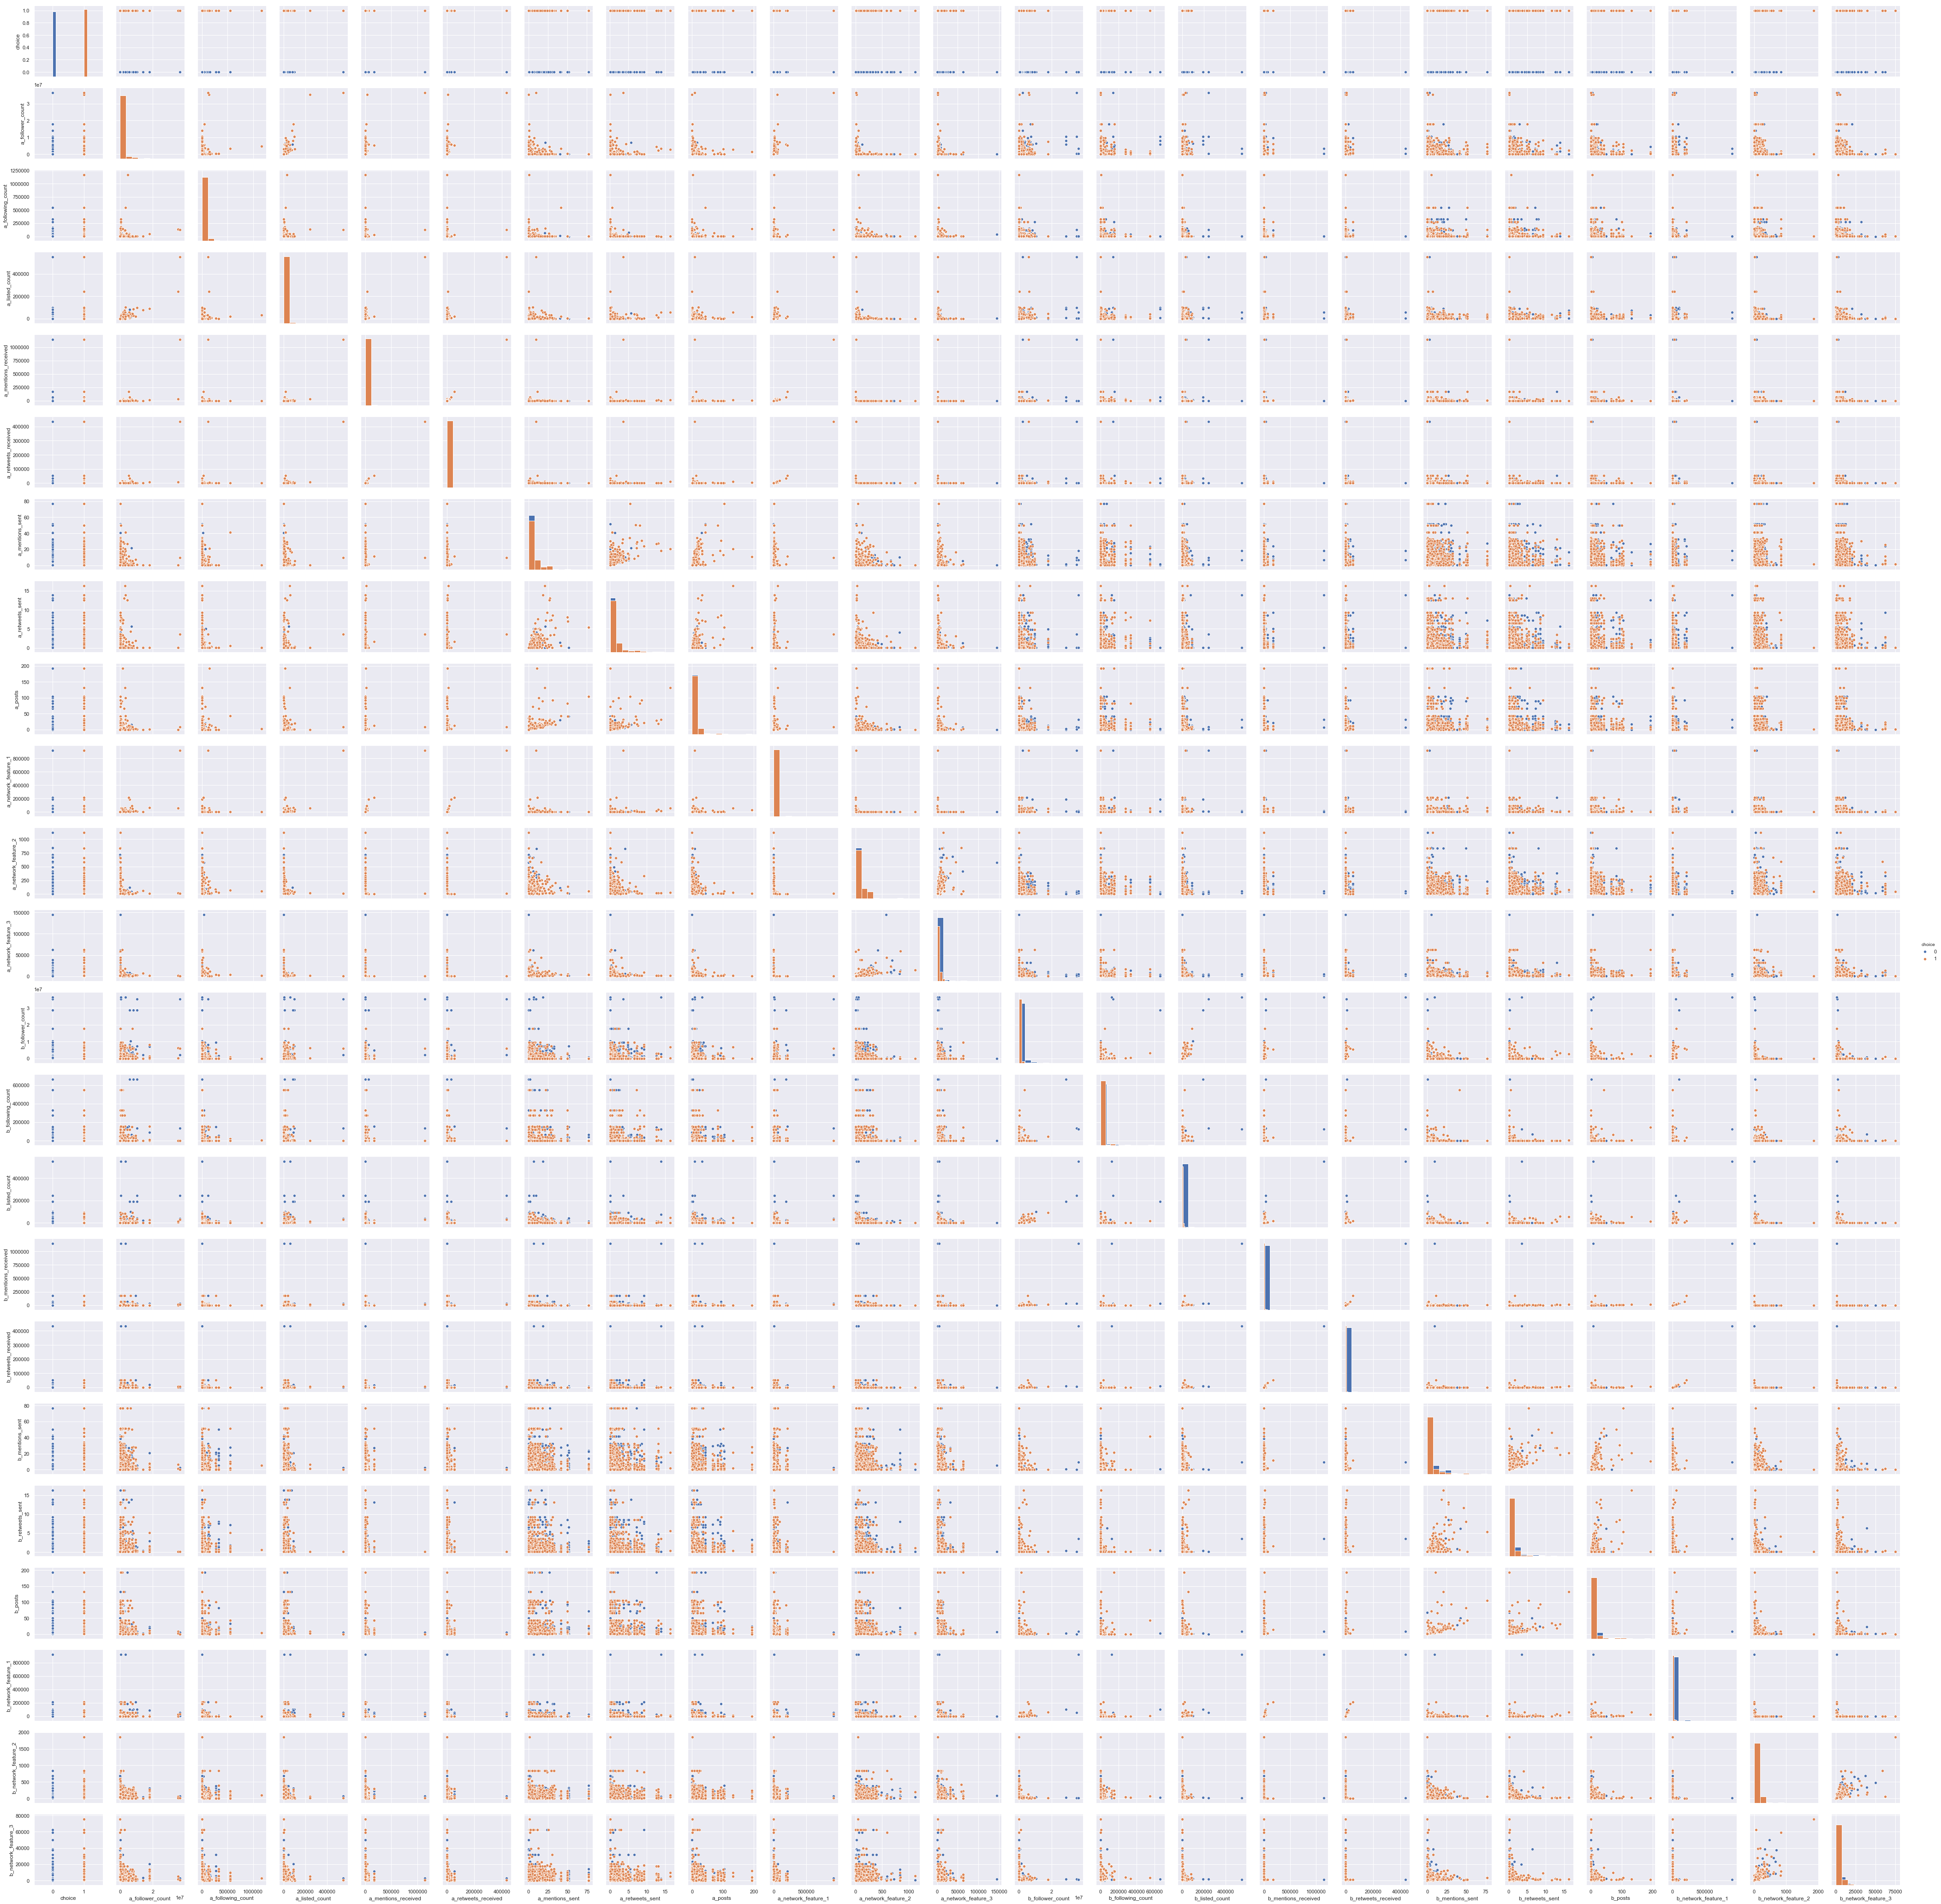

In [62]:
sns.pairplot(df, hue='choice', diag_kind='hist')


### feature density distribution

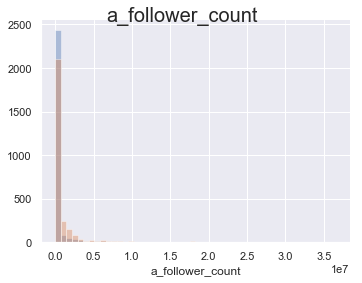

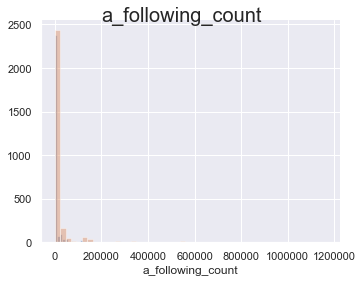

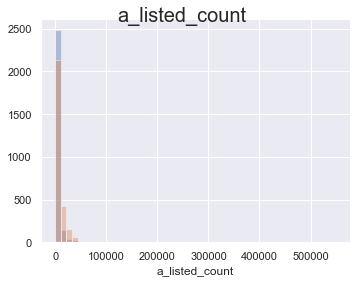

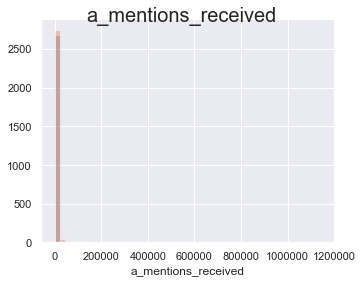

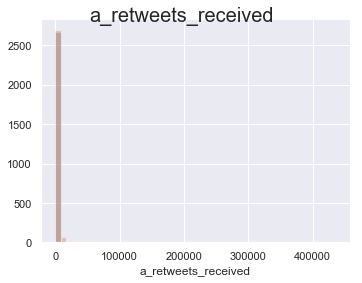

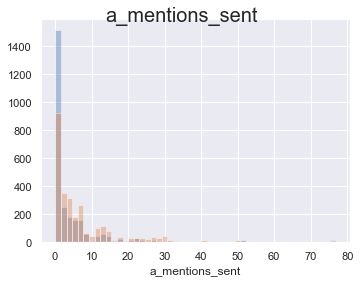

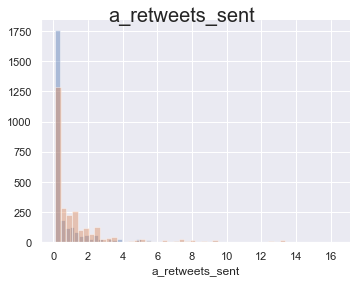

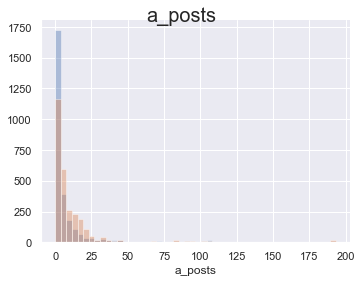

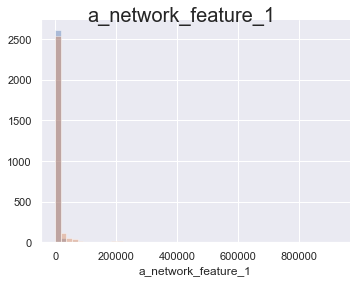

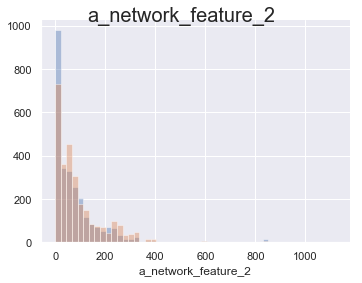

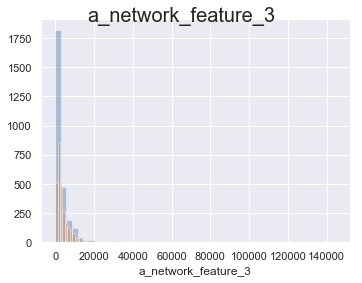

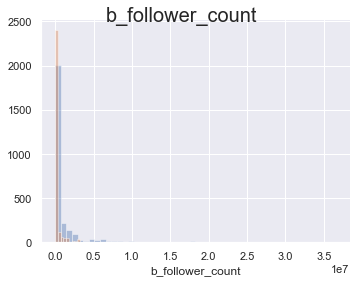

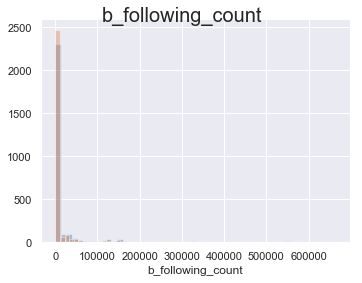

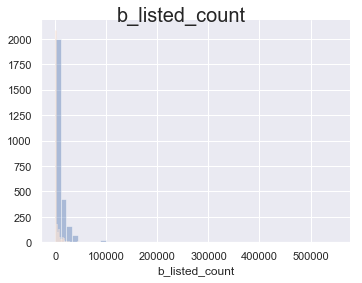

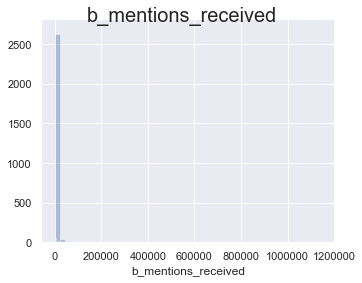

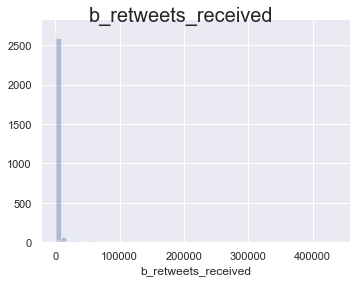

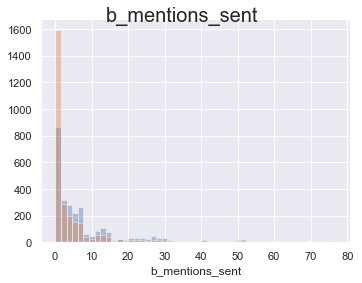

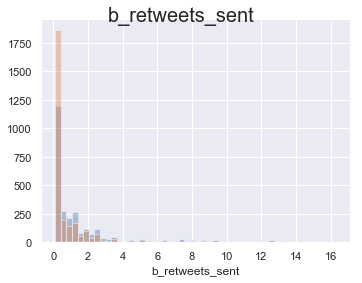

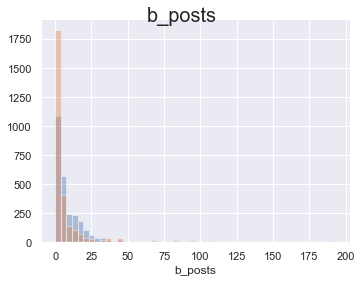

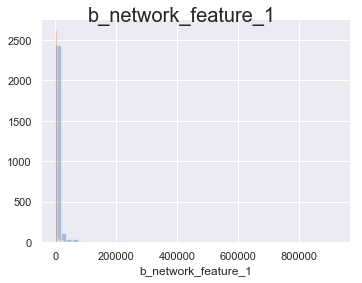

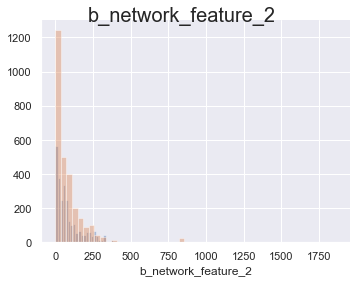

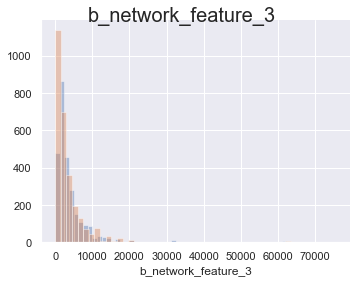

In [10]:
target_col = 'choice'
num_cols = df.select_dtypes(include='number').columns.drop(target_col)
for num_col in num_cols:
    plot_density(df, num_feat=num_col, hue_col=target_col, size=4)


### apply log transformation

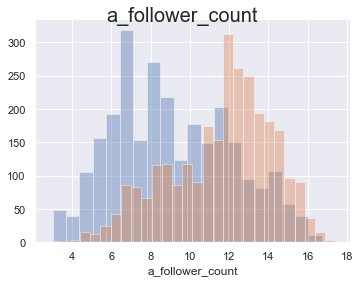

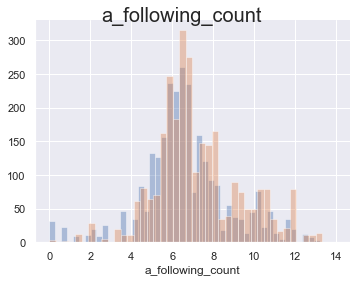

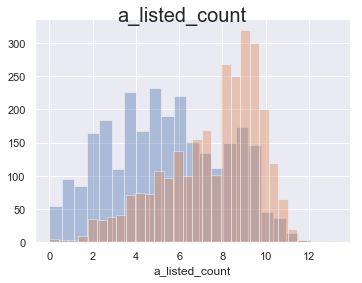

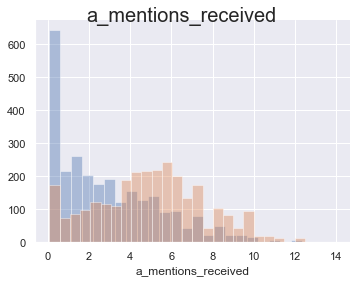

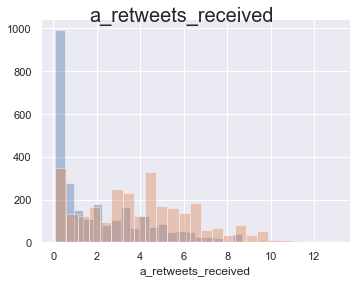

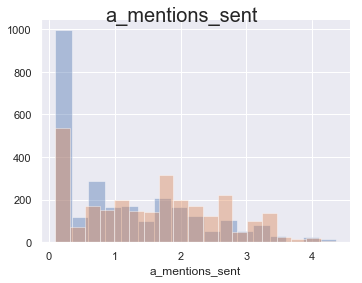

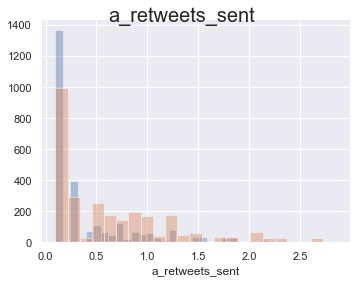

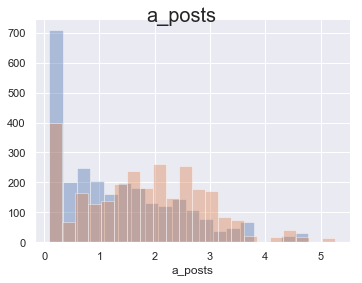

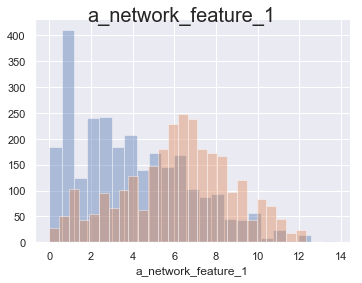

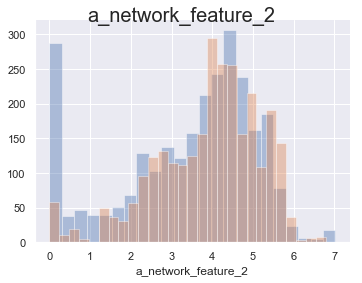

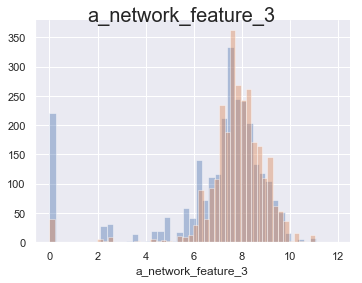

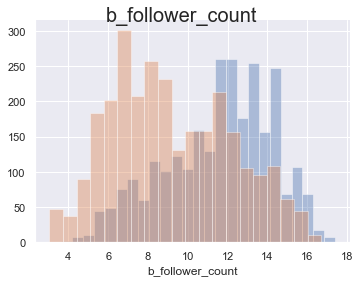

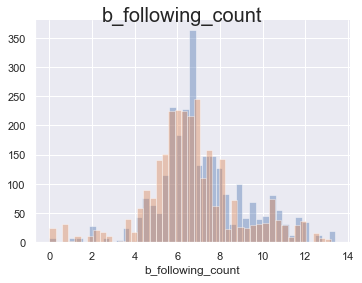

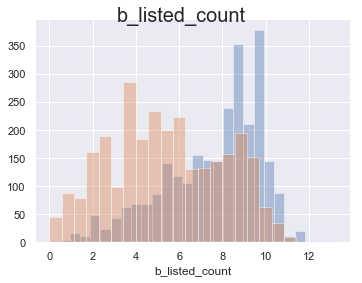

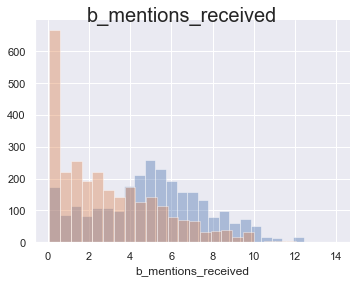

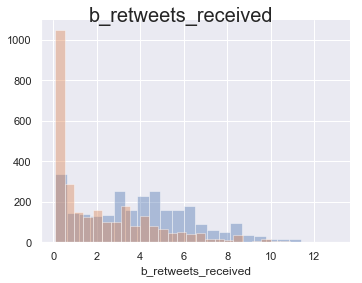

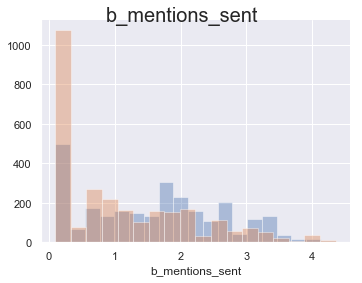

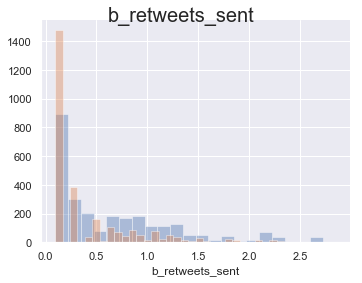

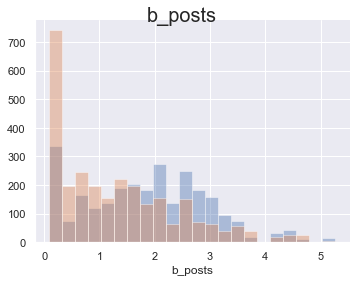

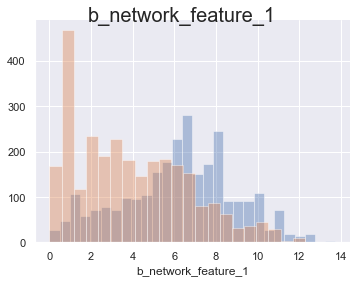

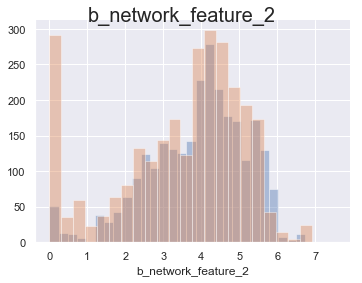

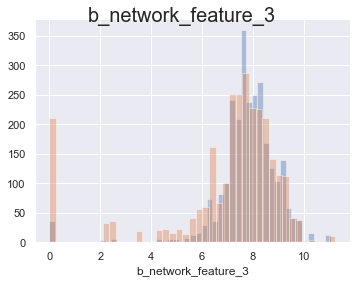

In [11]:
target_col = 'choice'
num_cols = df.select_dtypes(include='number').columns.drop(target_col)
df[num_cols] = np.log1p(df[num_cols])
for num_col in num_cols:
    plot_density(df, num_feat=num_col, hue_col=target_col, size=4)


TODO<BR>
compare feature distributions with test data

## correlation

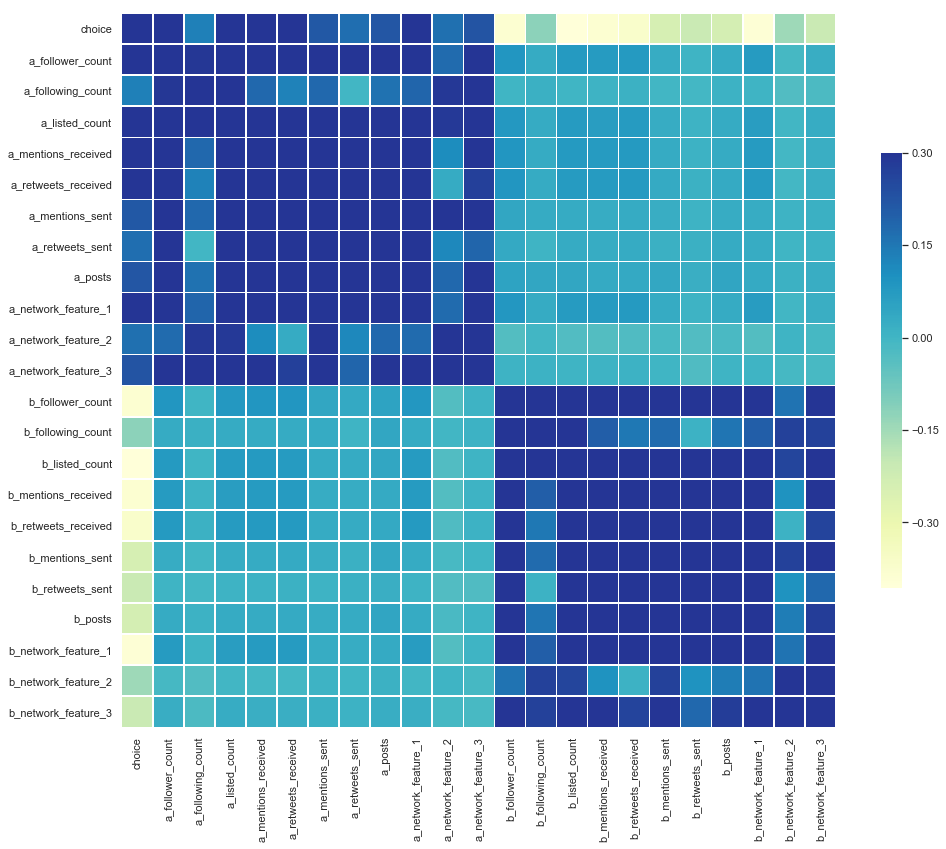

In [12]:
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), cmap='YlGnBu', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Takeaway

This is a traditional classification problem, the Dataset:<br>
&emsp;. contains 5,500 rows and 23 columns<br>
&emsp;. is balanced (same proportion between postive/negative classes)<br>
&emsp;. no missing values<br>
&emsp;. Most features are highly positively skweded due to the presence of extreme values (very long tail diestribution to the right)<br>
&emsp;. Applying a log transformation seems to help 'look like' a bell shape distribution for most features<br>
&emsp;. some features are 'weakly' positively correlated (within the range of [0.2-0.9])<br>


## PCA analysis

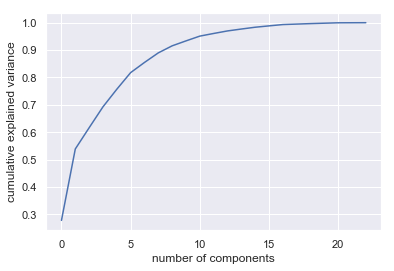

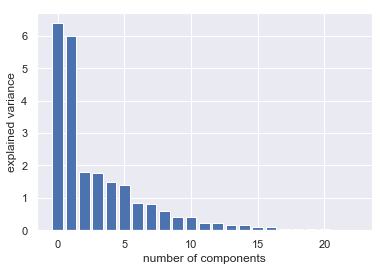

you need about 6 components to retain 80.0% of the variance


In [13]:
df = pd.read_csv('data/train.csv')
df.columns = df.columns.str.lower()

target_col = 'choice'
num_cols = df.select_dtypes(include='number').columns.drop(target_col)
# log tranformation
df[num_cols] = np.log1p(df[num_cols])
# scale data
scaler = StandardScaler()
# define X, y
X = scaler.fit_transform(df)
y = df[target_col]

# plot how mnay components
sns.set()
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('explained variance');
plt.show()

pct = 0.8
pca = PCA(pct).fit(X)

print('you need about {} components to retain {}% of the variance'.format(pca.n_components_, 100*pct))

4 to 6 components seem to be appropriate values without loosing too much imformation. This will reduce our dataset which contains alreadt 23 features. that could be interesting to test that which will reduce the training time of the model.

## What does affect the target the most? 

### using statiscal approach

In [14]:
n_top = 6

df = pd.read_csv('data/train.csv')
df.columns = df.columns.str.lower()

target_col = 'choice'
num_cols = df.select_dtypes(include='number').columns.drop(target_col)
# log tranformation
X = df[num_cols]
X_log = np.log1p(X)

# define target
y = df[target_col]
feature_selction(X, y, n_top)
# feature_selction(X_log, y, n_top)

<function chi2 at 0x11dab7ea0>



score  pvalue
a_follower_count     6.265994e+08     0.0
b_network_feature_1  8.794761e+06     0.0
b_posts              2.272185e+03     0.0
b_mentions_sent      1.661283e+03     0.0
b_retweets_received  2.019344e+06     0.0
b_mentions_received  5.264286e+06     0.0

Index(['a_follower_count', 'a_listed_count', 'b_follower_count',
       'b_listed_count', 'b_mentions_received', 'b_network_feature_1'],
      dtype='object')
<function f_classif at 0x11dab7d90>



score        pvalue
b_listed_count    208.572417  1.974003e-46
b_retweets_sent   160.349327  3.031391e-36
b_follower_count  146.825045  2.274924e-33
b_mentions_sent   109.149382  2.594181e-25
a_retweets_sent   106.473159  9.753260e-25
a_listed_count    102.181425  8.172171e-24

Index(['a_listed_count', 'a_retweets_sent', 'b_follower_count',
       'b_listed_count', 'b_mentions_sent', 'b_retweets_sent'],
      dtype='object')
<function mutual_info_classif at 0x11e182048>



score pvalue
a_follower_count     0.124290   None
a_following_count    0.104915   None
a_listed_count       0.107990   None
a_mentions_received  0.106755   None
a_retweets_received  0.120845   None
a_mentions_sent      0.073565   None

Index(['a_follower_count', 'a_retweets_received', 'a_network_feature_2',
       'b_follower_count', 'b_listed_count', 'b_mentions_received'],
      dtype='object')


using statiscal methods, we can see that the most relevant features affecting that target are:<br>
&emsp;. follower_count<br>
&emsp;. listed_count<br>
&emsp;. retweets_sent<br>
&emsp;. network_feature_1<br>

### using Recursive Feature Elimination (RFE) and cross-validated selection of the best number of features.


In [15]:
X = df.drop(columns='choice')
y = df['choice']

model = LGBMClassifier()

cv = StratifiedKFold(n_splits=5, random_state=123)
rfecv = RFECV(estimator=model,
              step=1,
              cv=cv,
              scoring='roc_auc',
              n_jobs=-1)
rfecv = rfecv.fit(X, y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
feature_names = pd.DataFrame(index=X.columns.tolist(),
                             data=rfecv.ranking_,
                             columns=['rank']).sort_values('rank', ascending=1)
feature_names

Optimal number of features : 12
Best features : Index(['a_follower_count', 'a_following_count', 'a_listed_count',
       'a_mentions_received', 'a_mentions_sent', 'a_network_feature_2',
       'b_follower_count', 'b_following_count', 'b_listed_count',
       'b_mentions_received', 'b_mentions_sent', 'b_network_feature_2'],
      dtype='object')


rank
a_follower_count        1
a_following_count       1
a_listed_count          1
a_mentions_received     1
b_mentions_sent         1
a_mentions_sent         1
b_mentions_received     1
b_listed_count          1
b_following_count       1
a_network_feature_2     1
b_network_feature_2     1
b_follower_count        1
b_network_feature_3     2
a_network_feature_3     3
a_retweets_received     4
a_posts                 5
b_posts                 6
b_retweets_received     7
b_network_feature_1     8
a_retweets_sent         9
b_retweets_sent        10
a_network_feature_1    11

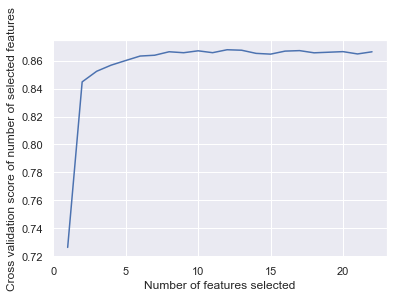

In [263]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

using RFE, the most relevant features that distinguish 2 users from popular to normal are the:<br>
&emsp;. follower_count<br>
&emsp;. following_count<br>
&emsp;. listed_count<br>
&emsp;. mentions_received<br>
&emsp;. mentions_sent<br>
&emsp;. network_feature_2<br>
       

## using model feature importance

In [22]:
X = df.drop(columns='choice')
y = df['choice']
sns.set()
models = {'xgboost': XGBClassifier(),
          'lgb': LGBMClassifier(),
          'RF': RandomForestClassifier(),
          'Adaboost': AdaBoostClassifier(),
          'extratree': ExtraTreesClassifier()}

for name, model in models.items():

    print(name)
    fit = model.fit(X, y)
    display(eli5.show_weights(model, show=['feature_importances', 'targets', 'transition_features'],
                              top=10,
                              feature_names=X.columns.tolist()))
#     if isinstance(model, XGBClassifier):
#         xgb.plot_importance(fit, importance_type='weight', title='xgb Feature importance (weight)');
# #         xgb.plot_importance(fit, importance_type='gain', title='xgb Feature importance (gain)');
# #         xgb.plot_importance(fit, importance_type='cover', title='xgb Feature importance (cover)');
# #         xgb.plot_tree(model)
#     if isinstance(model, LGBMClassifier):
#         lgbm.plot_importance(fit, importance_type='split', title='lgbm Feature importance (split)');
# #         lgbm.plot_importance(fit, importance_type='gain', title='lgbm Feature importance (gain)');
# #         lgbm.plot_tree(model)        




xgboost


lgb


RF


Adaboost


extratree


as you can see most of the top features are those previously selected by other methods

### using partial dependent plots

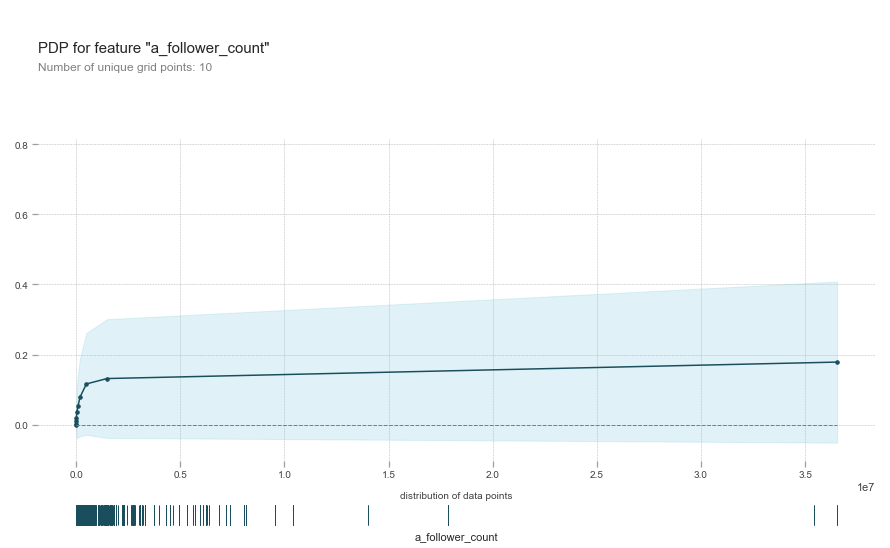

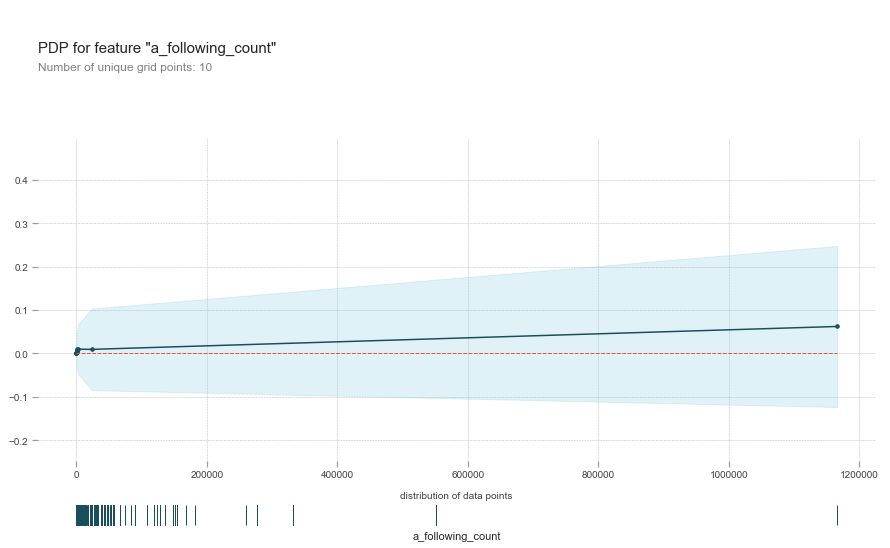

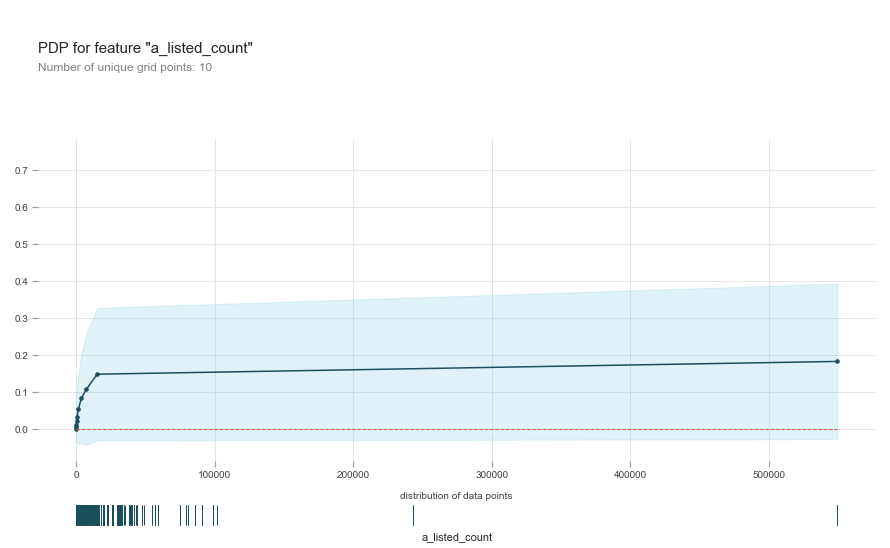

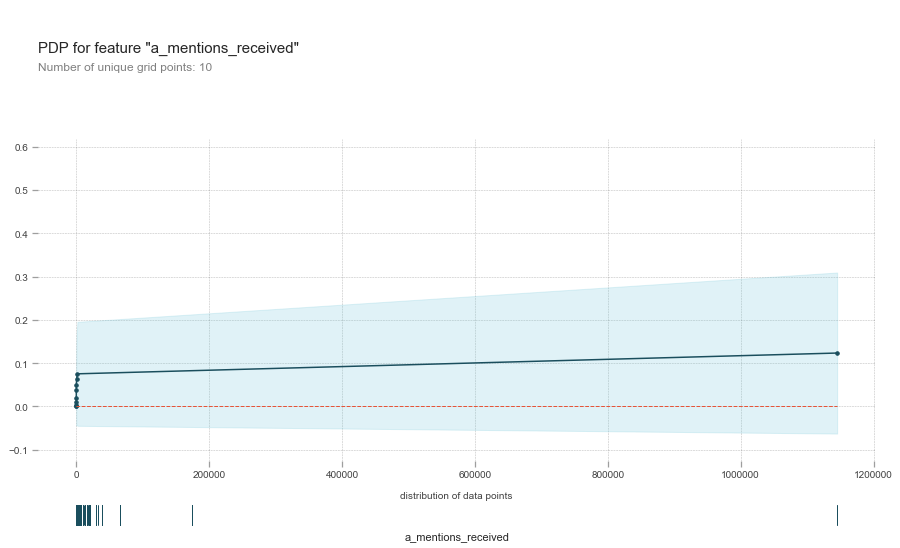

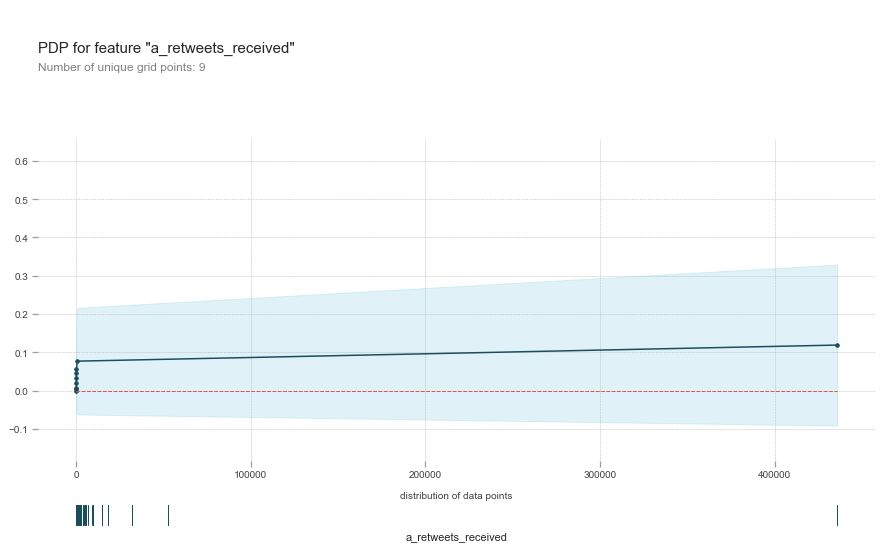

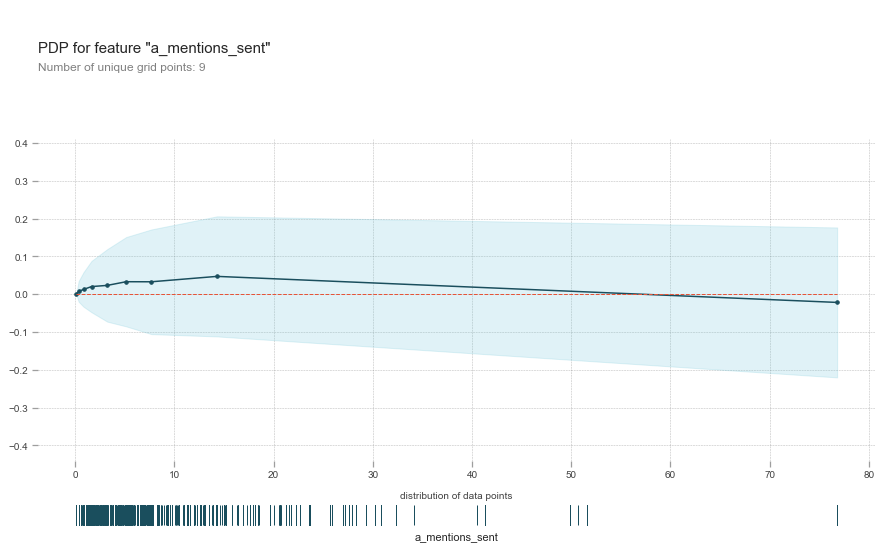

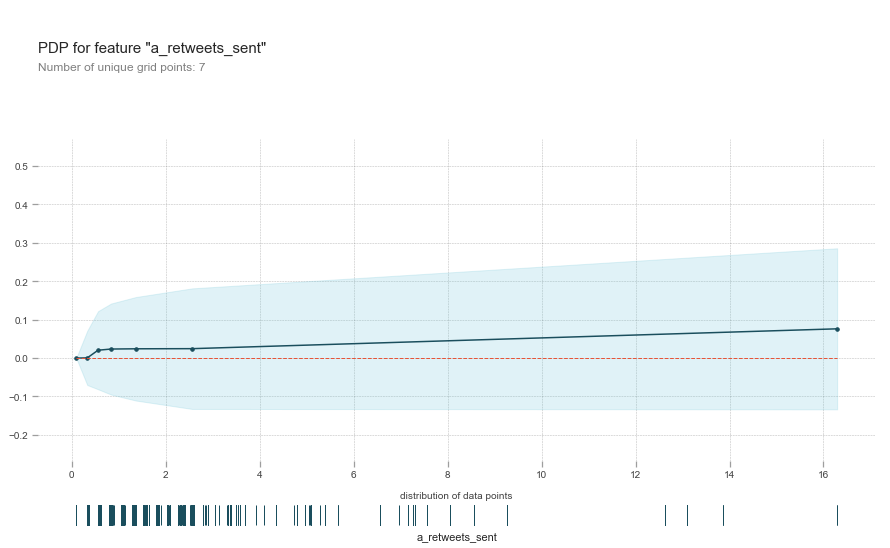

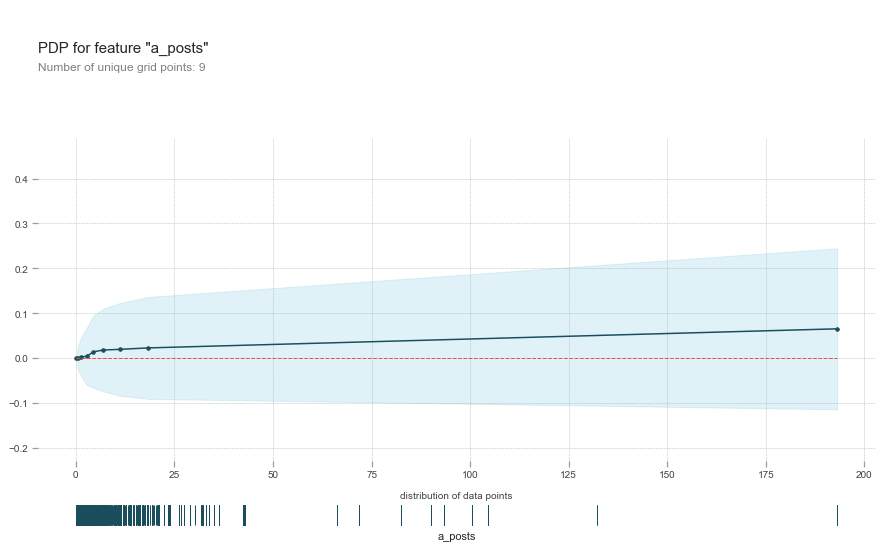

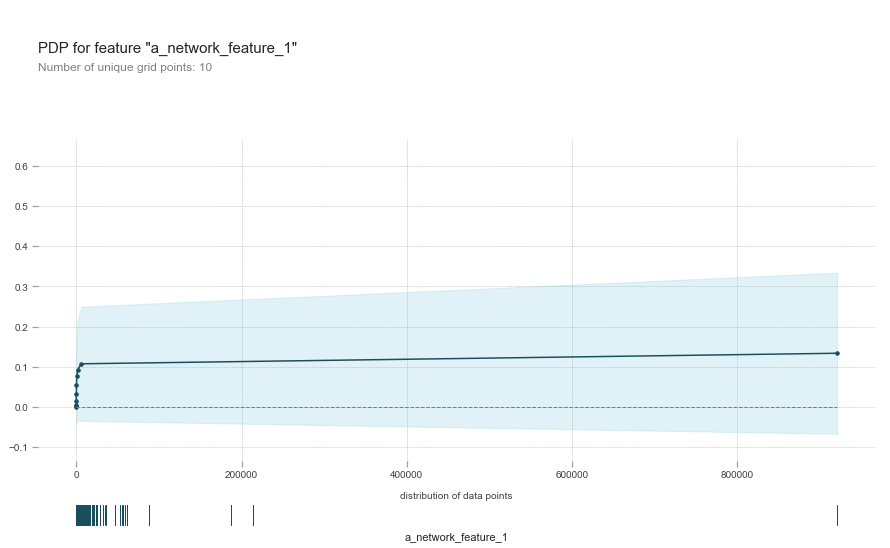

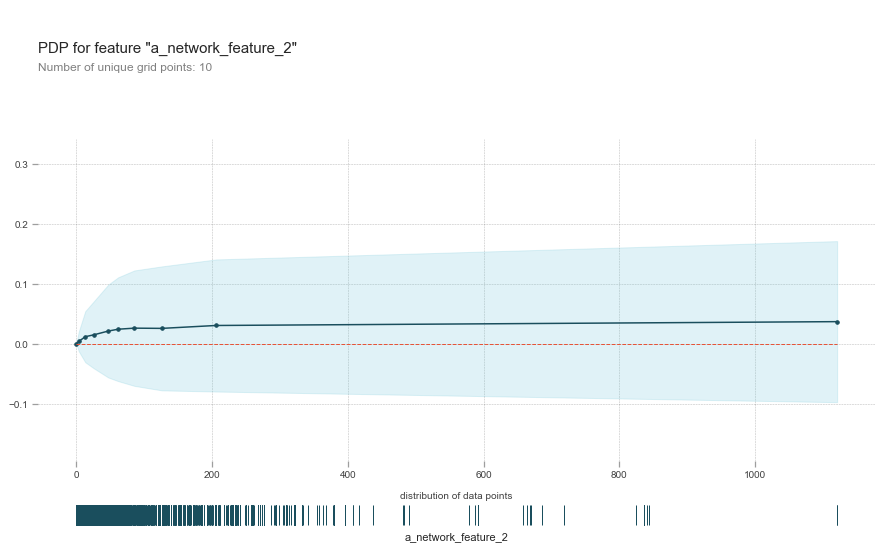

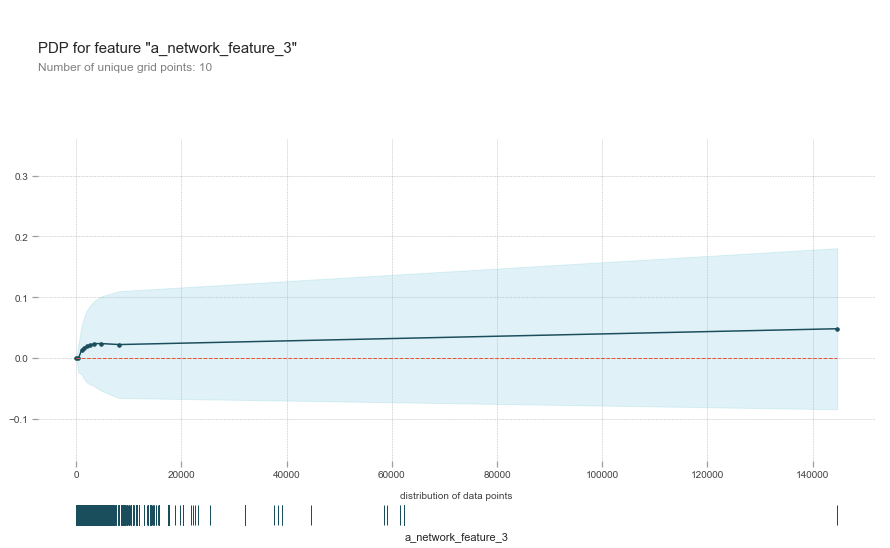

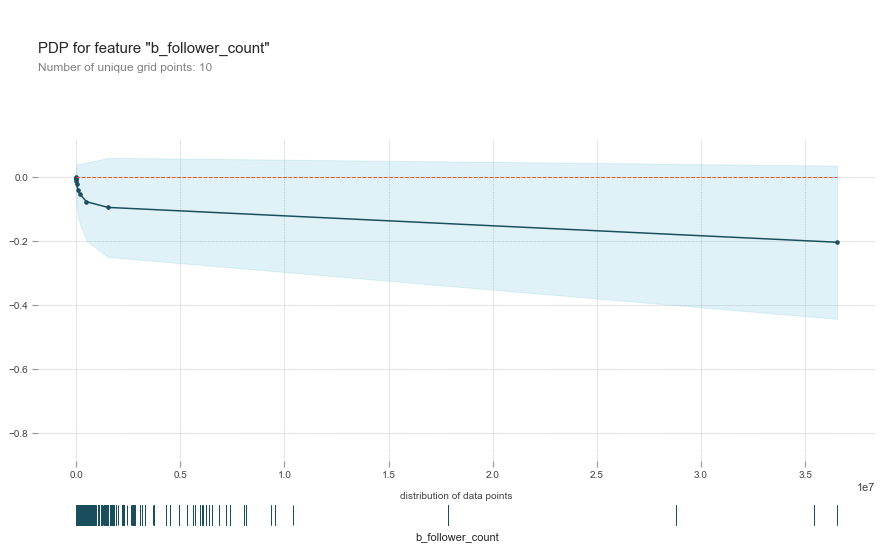

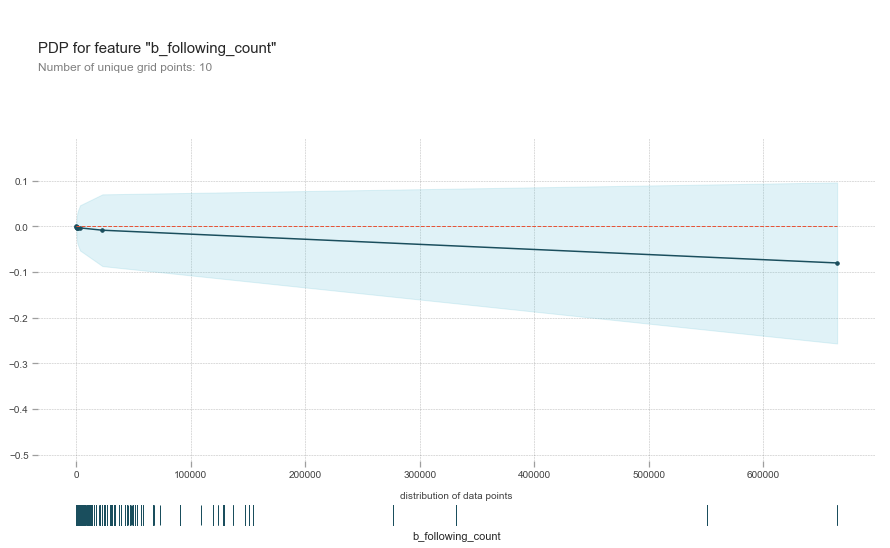

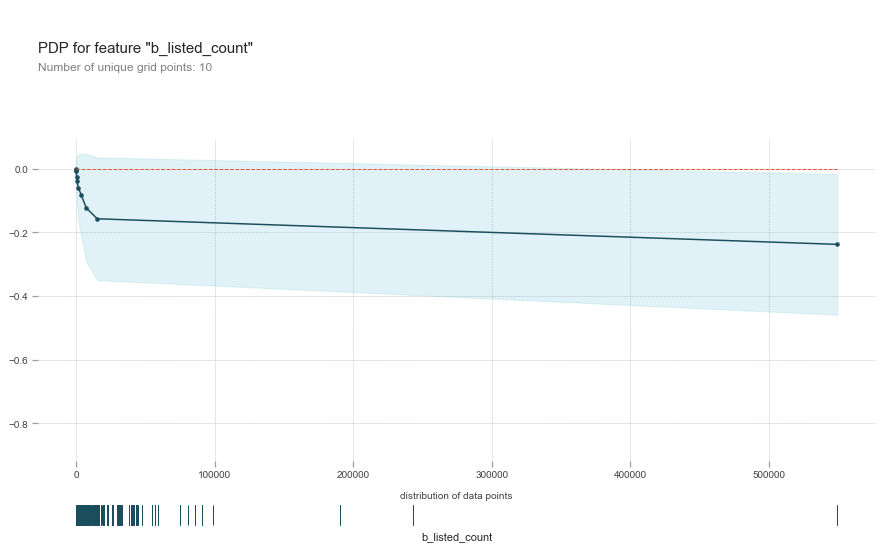

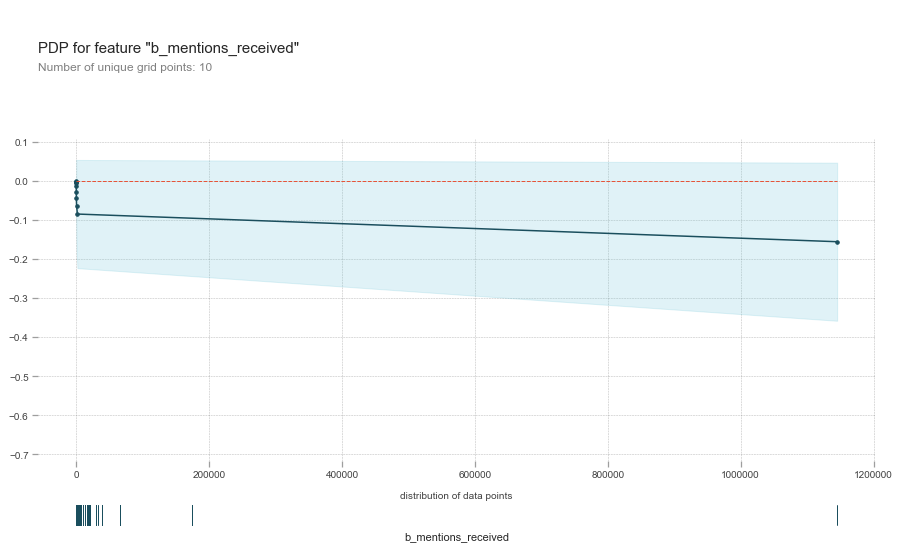

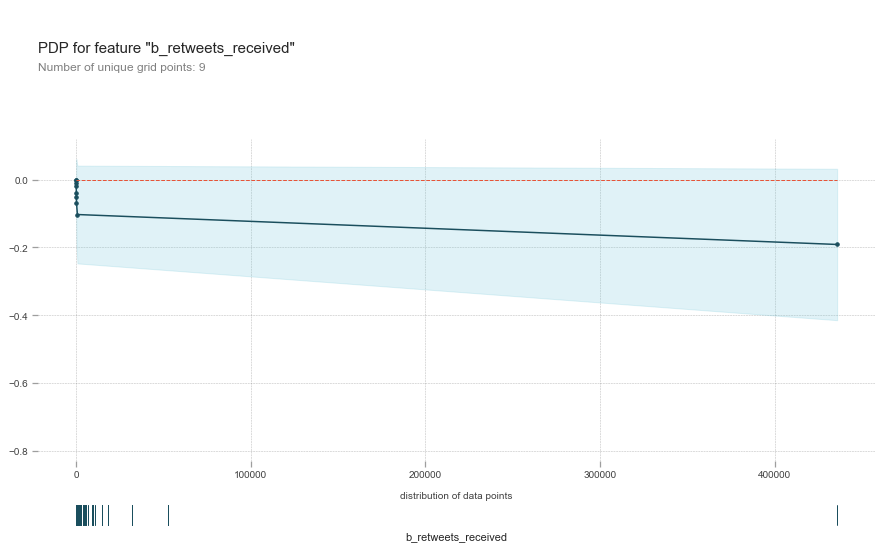

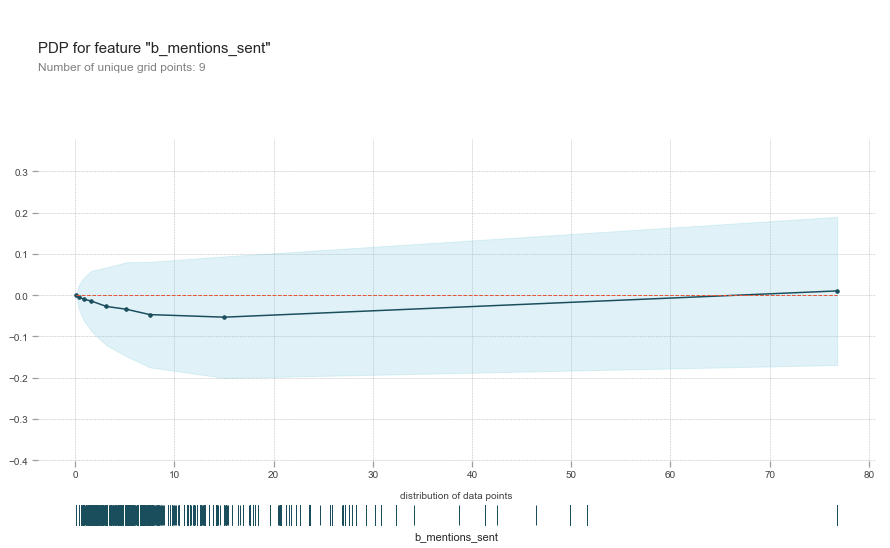

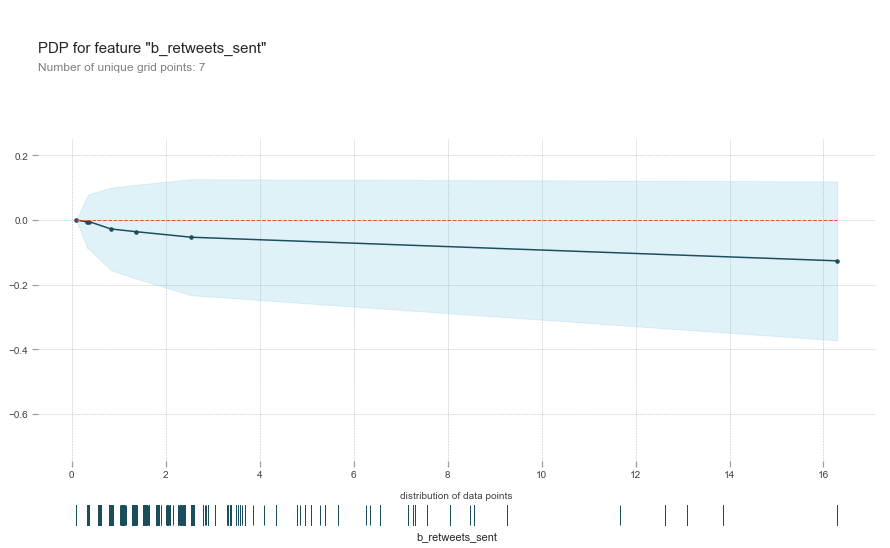

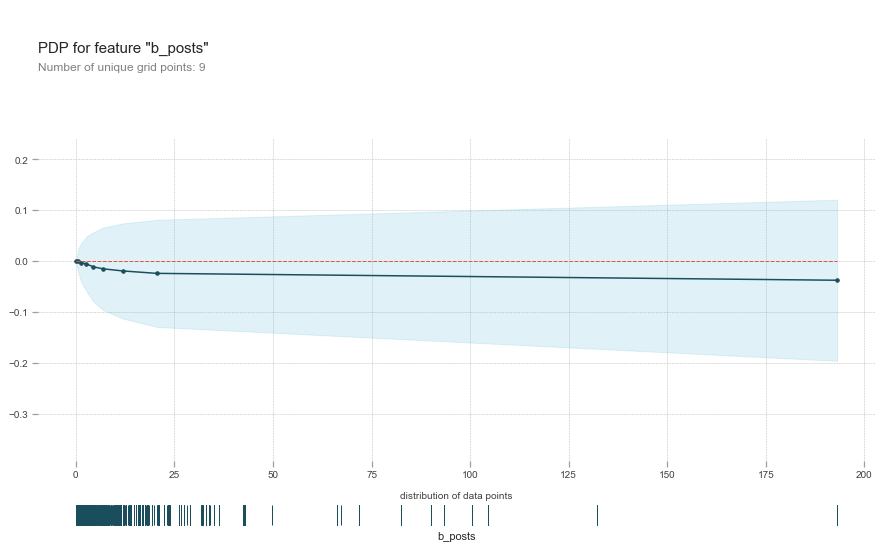

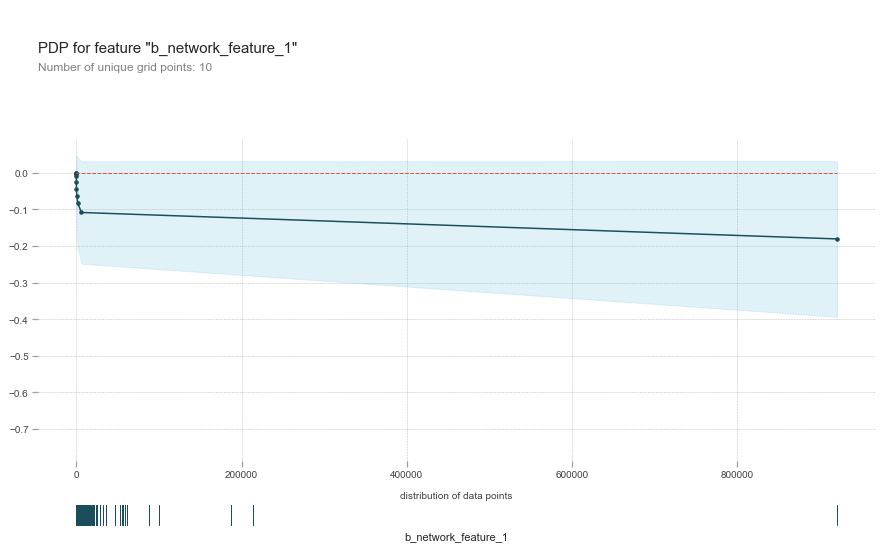

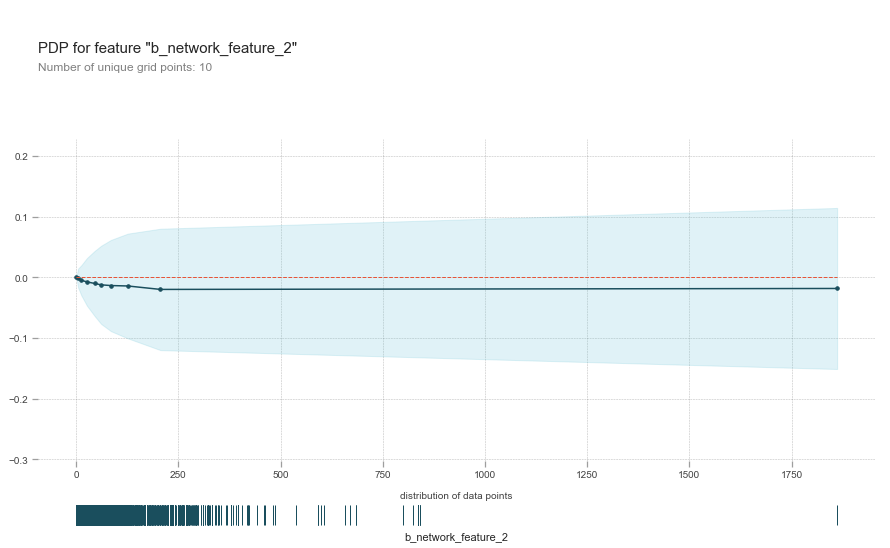

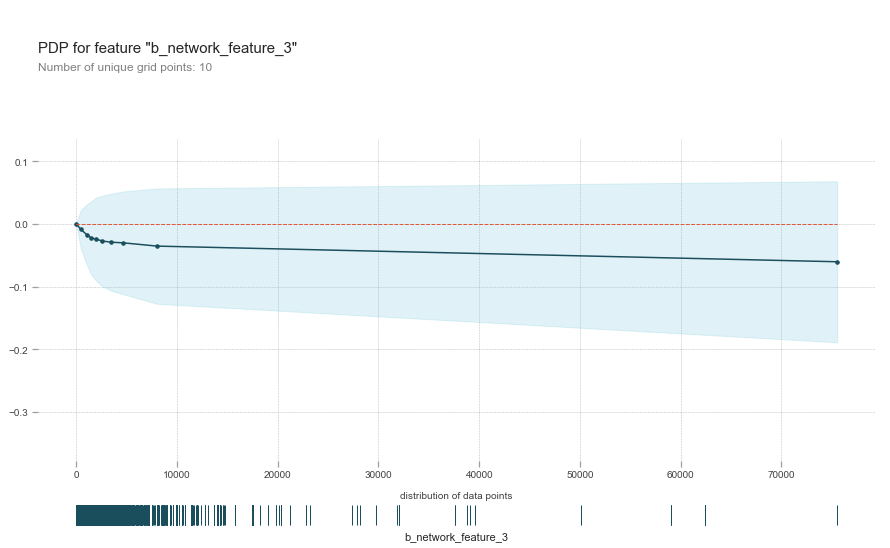

In [23]:
X = df.drop(columns='choice')
y = df['choice']
sns.set()

for col in X.columns:
    feature_names = X.loc[:, X.columns.str.startswith(col)].columns.tolist()
    pdp_ = pdp.pdp_isolate(model=model,
                                dataset=X,
                                model_features=X.columns,
                                feature=feature_names if len(feature_names) > 1 else feature_names[0])

    pdp.pdp_plot(pdp_, col, center=True, 
                 plot_lines=False,  
    #              frac_to_plot=100,  
                 plot_pts_dist=True)
    plt.show()

NOTE:<br>
partial independent plots are intersting in a sense that they will tell in what direction a feature will affect the target.
Any increased values of A features tend to increase his likehood of being more more popolar than B.
On the other hand an increased value of b_ feature will tend to decrease the likehood of A for being popular which
make sense.

### interaction plots

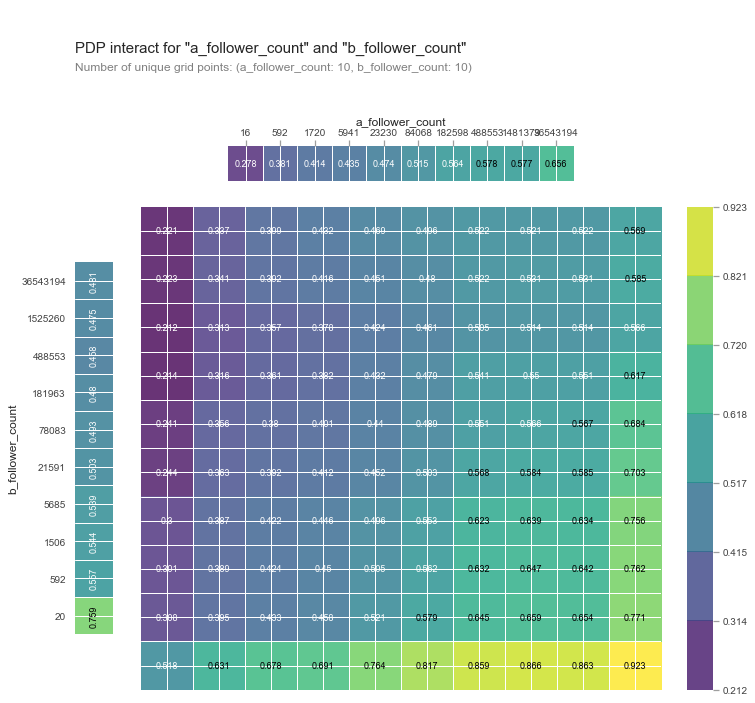

In [29]:
features_to_plot = ['a_follower_count', 'b_follower_count']
inter1 = pdp.pdp_interact(model=model,
                          dataset=X,
                          model_features=X.columns,
                          features=features_to_plot)


fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1,
                      feature_names=features_to_plot,
                      plot_type='grid',
                      x_quantile=True,
                      plot_pdp=True)
plt.show()

NOTE:<br>
The interaction plot between a_follower_count and b_follower_count features (for example) will confirm the previous statment.

## Baseline predictions 
&emsp;. no data transformation<br>
&emsp;. no feature engineering<br>
&emsp;. default model values<br>
&emsp;. no hypertuning<br>

### train model + predictions

In [24]:
# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=123)
# train model with default values
model = LGBMClassifier()
fit = model.fit(X_train, y_train)
y_pred = fit.predict(X_test)

### evaluate model

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       809
           1       0.78      0.76      0.77       841

    accuracy                           0.77      1650
   macro avg       0.77      0.77      0.77      1650
weighted avg       0.77      0.77      0.77      1650



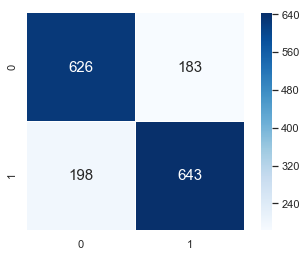

In [25]:
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),
            cmap="Blues",
            square=True,
            linewidths=0.1,
            annot=True,
            fmt='g',
            annot_kws={"size": 15});


### plot AUC

ROC-AUC Score: 0.8559031937081202


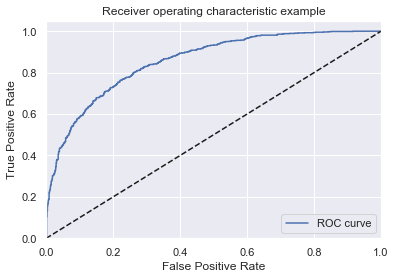

In [26]:
# Compute ROC curve and ROC area for each class
preds = model.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, preds)
print("ROC-AUC Score: {}".format(roc_auc_score(y_test, preds)))
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### plot tree

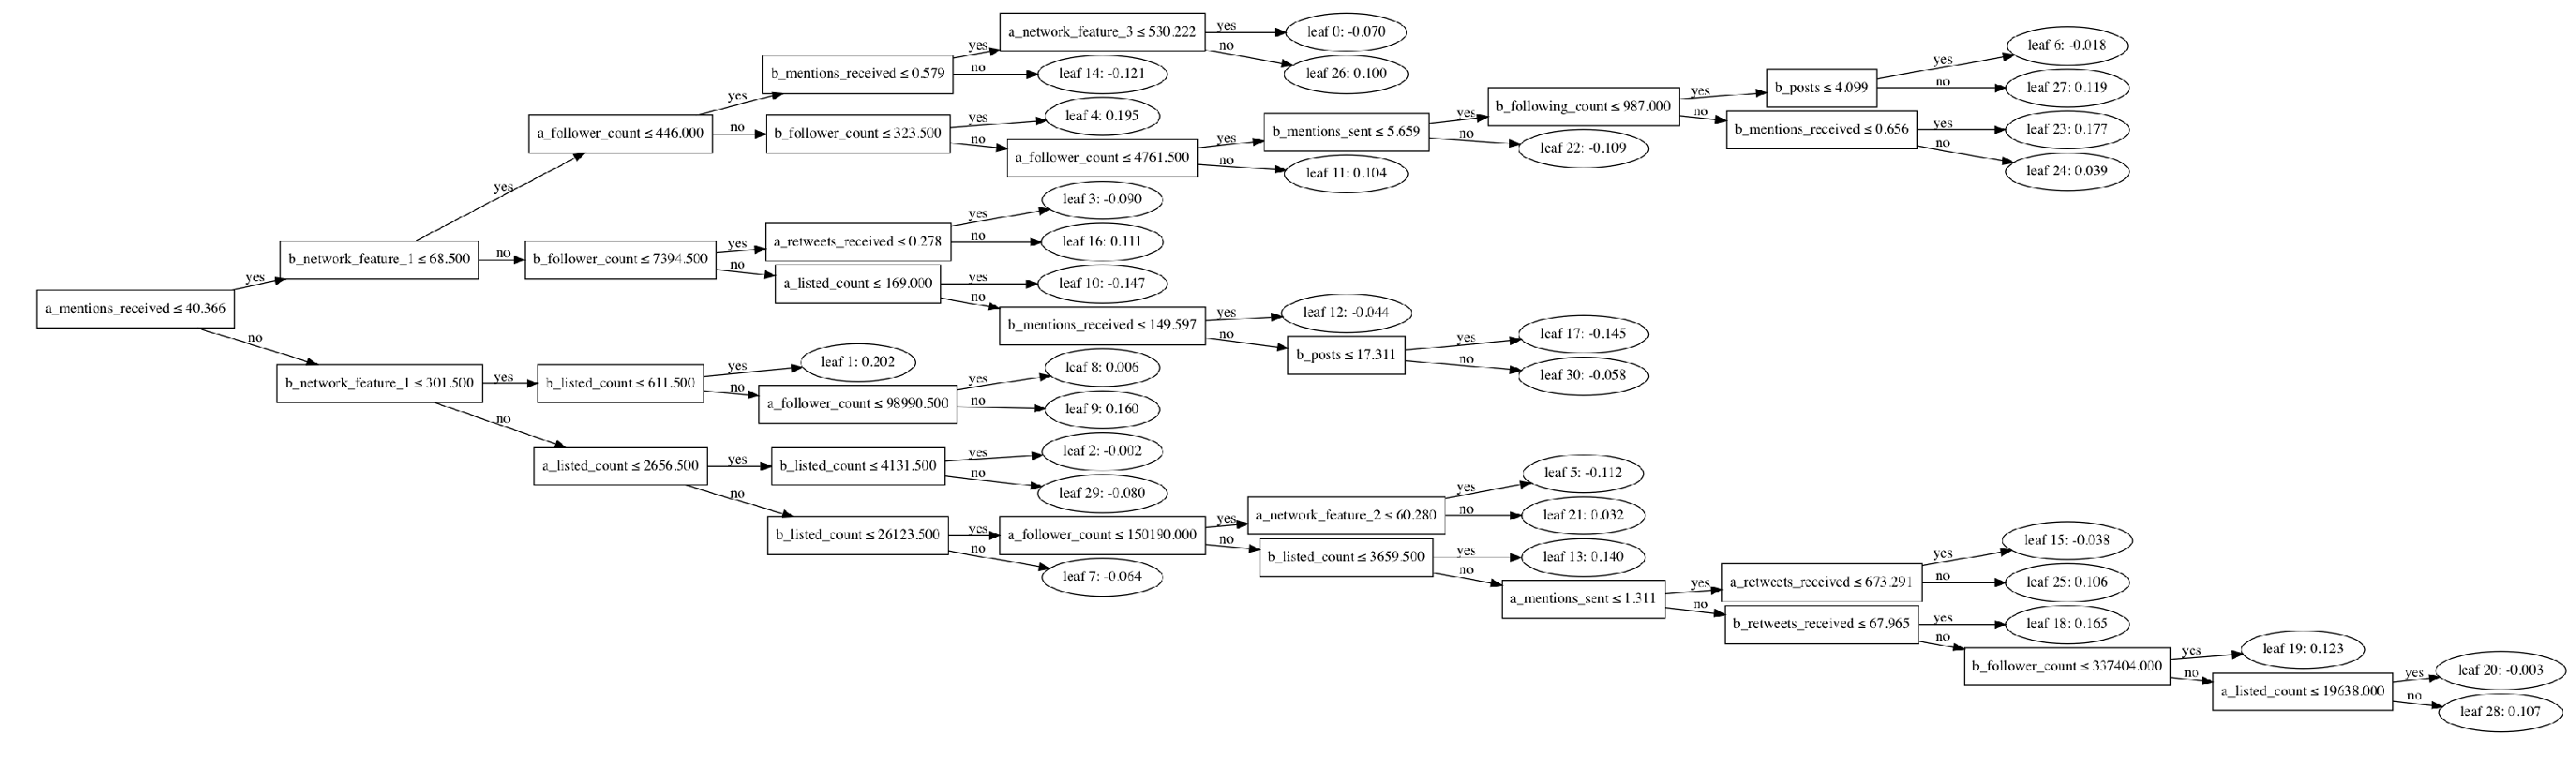

In [33]:
from lightgbm import plot_tree
plot_tree(model)
# plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(48.5, 48.5)
plt.show()
# plt.show;